In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# both are used to load MNIST dataset but load_digits is for a smaller version of MNIST
from sklearn.datasets import fetch_openml
from sklearn.datasets import load_digits

# using cuml to train on the GPU
from sklearn.linear_model import LogisticRegression
from cuml.linear_model import LogisticRegression as cuLogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# downloading full MNIST dataset (70k images)
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(np.uint8)

In [3]:
print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")

Dataset shape: (70000, 784)
Number of classes: 10


In [4]:
# splittin the data (20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# normalizing the data (range from 0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 56000
Test set size: 14000


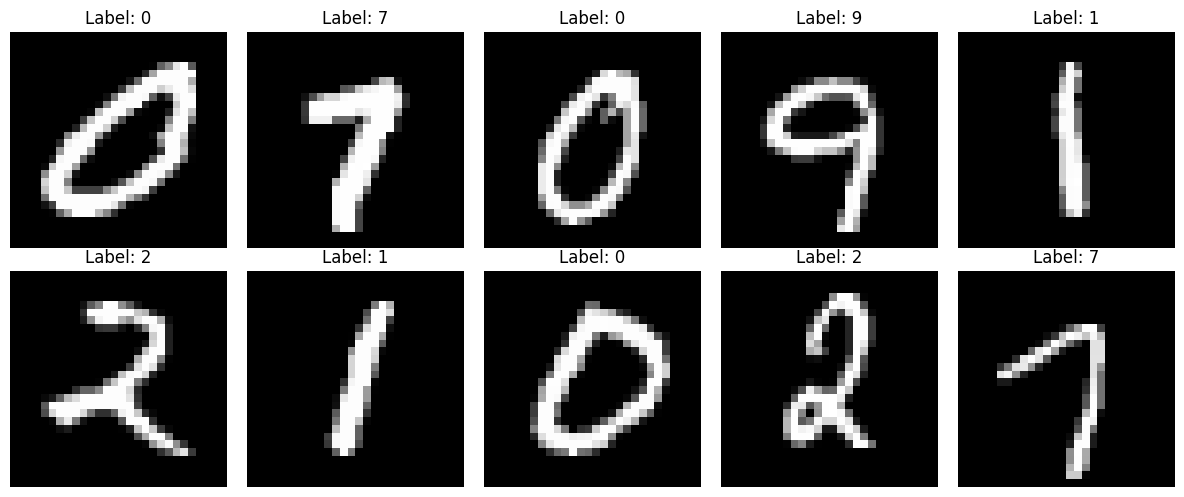

In [5]:
# plot to display 10 images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

# flatten the grid into a 1D list for looping
for i, ax in enumerate(axes.ravel()):
    # reshape and show the image in grayscale
    ax.imshow(X_train[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# GPU-accelerated
model = cuLogisticRegression(
    solver='qn',
    max_iter=1000,
    tol=0.001,             # tolerance to stop when improvement is small
    output_type='numpy'    # return as numpy arrat instead of cuDF
)

model.fit(X_train, y_train)

LogisticRegression()

In [7]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.9205


In [8]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1381
           1       0.95      0.97      0.96      1575
           2       0.92      0.90      0.91      1398
           3       0.90      0.89      0.89      1428
           4       0.93      0.92      0.93      1365
           5       0.88      0.87      0.88      1263
           6       0.94      0.95      0.94      1375
           7       0.93      0.94      0.94      1459
           8       0.89      0.88      0.89      1365
           9       0.90      0.89      0.90      1391

    accuracy                           0.92     14000
   macro avg       0.92      0.92      0.92     14000
weighted avg       0.92      0.92      0.92     14000



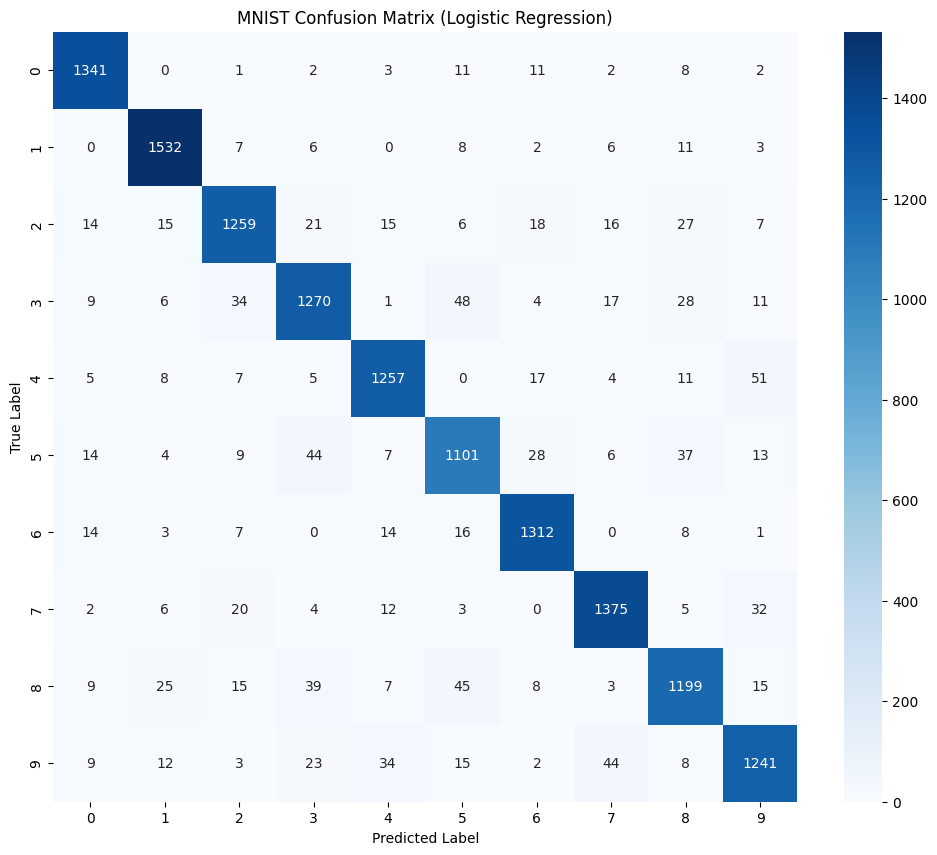

In [9]:
# confusion matrix
plt.figure(figsize=(12, 10))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10),
            yticklabels=range(10))
plt.title('MNIST Confusion Matrix (Logistic Regression)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [12]:
for i in range(10):
  img_path = f"/content/{i}.png"

  img = cv2.imread(img_path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  resize = cv2.resize(gray, (28, 28))
  invert = 255 - resize
  normalize = invert / 255.0
  flatten = normalize.reshape(1, -1)

  pred = model.predict(flatten)[0]
  prob = model.predict_proba(flatten)[0]
  confidence = np.max(prob)

  print(f"Image {i}: Predicted digit = {pred}")
  print(f"Confidence: {confidence:.3f}")
  print("-" * 50)

Image 0: Predicted digit = 0
Confidence: 0.997
--------------------------------------------------
Image 1: Predicted digit = 1
Confidence: 0.998
--------------------------------------------------
Image 2: Predicted digit = 2
Confidence: 0.949
--------------------------------------------------
Image 3: Predicted digit = 3
Confidence: 0.999
--------------------------------------------------
Image 4: Predicted digit = 4
Confidence: 0.998
--------------------------------------------------
Image 5: Predicted digit = 5
Confidence: 0.850
--------------------------------------------------
Image 6: Predicted digit = 6
Confidence: 0.991
--------------------------------------------------
Image 7: Predicted digit = 7
Confidence: 0.998
--------------------------------------------------
Image 8: Predicted digit = 8
Confidence: 0.960
--------------------------------------------------
Image 9: Predicted digit = 9
Confidence: 0.728
--------------------------------------------------


In [13]:
# saving the model
with open('MNIST_Logistic_Regression_GPU.pkl', 'wb') as f:
    pickle.dump(model, f)